# EEG Data Preprocessing

## Converting Files to CSVs

In [1]:
# Notebook: EEG File Converter to CSV with Integrated Annotations
import os
import mne
import pandas as pd

# Suppress MNE warnings
mne.set_log_level('ERROR')

# Define paths
root_path = './data/selfmade_dataset/'       # adjust if necessary
output_path = './csv_output/'

# Ensure output directory exists
os.makedirs(output_path, exist_ok=True)

# Channels to mark as misc
misc_chs = ['Aux1', 'Aux2', 'x_dir', 'y_dir', 'z_dir']

# Iterate over Person and Recording folders
for person_dir in sorted(os.listdir(root_path)):
    person_path = os.path.join(root_path, person_dir)
    if not os.path.isdir(person_path):
        continue

    for recording_dir in sorted(os.listdir(person_path)):
        recording_path = os.path.join(person_path, recording_dir)
        if not os.path.isdir(recording_path):
            continue

        # Process .vhdr files
        for file in sorted(os.listdir(recording_path)):
            if not file.endswith('.vhdr'):
                continue

            vhdr_path = os.path.join(recording_path, file)
            basename = file[:-5]  # strip .vhdr

            # Fix .vhdr references
            with open(vhdr_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
            with open(vhdr_path, 'w', encoding='utf-8') as f:
                for line in lines:
                    if line.startswith('DataFile='):
                        f.write(f'DataFile={basename}.eeg\n')
                    elif line.startswith('MarkerFile='):
                        f.write(f'MarkerFile={basename}.vmrk\n')
                    else:
                        f.write(line)

            # Load raw data, specifying eog as empty list and misc channels
            raw = mne.io.read_raw_brainvision(
                vhdr_path,
                preload=True,
                eog=[],
                misc=misc_chs
            )

            # Convert to DataFrame
            df = raw.to_data_frame()

            # Add annotation column, default ''
            df['annotation'] = ''
            if raw.annotations and len(raw.annotations) > 0:
                for onset, duration, desc in zip(raw.annotations.onset,
                                                 raw.annotations.duration,
                                                 raw.annotations.description):
                    mask = (df['time'] >= onset) & (df['time'] < onset + duration)
                    df.loc[mask, 'annotation'] = desc

            # Save combined CSV
            out_csv = os.path.join(output_path, f'{basename}.csv')
            df.to_csv(out_csv, index=False)
            print(f'Saved combined CSV: {out_csv}')


Saved combined CSV: ./csv_output/Person1Recording1.csv
Saved combined CSV: ./csv_output/Person1Recording2.csv
Saved combined CSV: ./csv_output/Person1Recording3.csv
Saved combined CSV: ./csv_output/Person1Recording3.csv
Saved combined CSV: ./csv_output/Person2Recording1.csv
Saved combined CSV: ./csv_output/Person2Recording2.csv
Saved combined CSV: ./csv_output/Person2Recording3.csv
Saved combined CSV: ./csv_output/Person3Recording1.csv
Saved combined CSV: ./csv_output/Person3Recording2.csv
Saved combined CSV: ./csv_output/Person3Recording3.csv
Saved combined CSV: ./csv_output/Person4Recording1.csv
Saved combined CSV: ./csv_output/Person4Recording2.csv


## Extend annotations for all rows and clean annotations 

In [2]:
import os, pandas as pd, numpy as np

for file in sorted(os.listdir(output_path)):
    if not file.endswith('.csv'):
        continue
    csv_file = os.path.join(output_path, file)
    df = pd.read_csv(csv_file)

    # Replace empty strings with NaN for ffill
    df['annotation'] = df['annotation'].replace('', np.nan)
    # Remove 'Stimulus/' prefix
    df['annotation'] = df['annotation'].str.replace(r'^Stimulus/', '', regex=True)
    # Forward-fill
    df['annotation'] = df['annotation'].ffill()
    df['annotation'] = df['annotation'].fillna('')

    df.to_csv(csv_file, index=False)
    print(f'Updated annotations in: {csv_file}')


Updated annotations in: ./csv_output/Person1Recording1.csv
Updated annotations in: ./csv_output/Person1Recording2.csv
Updated annotations in: ./csv_output/Person1Recording3.csv
Updated annotations in: ./csv_output/Person2Recording1.csv
Updated annotations in: ./csv_output/Person2Recording2.csv
Updated annotations in: ./csv_output/Person2Recording3.csv
Updated annotations in: ./csv_output/Person3Recording1.csv
Updated annotations in: ./csv_output/Person3Recording2.csv
Updated annotations in: ./csv_output/Person3Recording3.csv


C:\Users\aksel\AppData\Local\Temp\ipykernel_59176\794490201.py:7: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


Updated annotations in: ./csv_output/Person4Recording1.csv


C:\Users\aksel\AppData\Local\Temp\ipykernel_59176\794490201.py:7: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


Updated annotations in: ./csv_output/Person4Recording2.csv


## Add columns for Person and Recording

In [3]:
import os, re, pandas as pd

for file in sorted(os.listdir(output_path)):
    if not file.endswith('.csv'):
        continue
    csv_file = os.path.join(output_path, file)
    m = re.match(r'Person(\d+)Recording(\d+)\.csv$', file)
    if not m:
        print(f"Filename does not match pattern: {file}")
        continue
    person_num, recording_num = map(int, m.groups())

    df = pd.read_csv(csv_file)
    df.insert(0, 'Recording', recording_num)
    df.insert(0, 'Person',    person_num)
    df.to_csv(csv_file, index=False)
    print(f'Added Person and Recording columns in: {csv_file}')


Added Person and Recording columns in: ./csv_output/Person1Recording1.csv
Added Person and Recording columns in: ./csv_output/Person1Recording2.csv
Added Person and Recording columns in: ./csv_output/Person1Recording3.csv
Added Person and Recording columns in: ./csv_output/Person2Recording1.csv
Added Person and Recording columns in: ./csv_output/Person2Recording2.csv
Added Person and Recording columns in: ./csv_output/Person2Recording3.csv
Added Person and Recording columns in: ./csv_output/Person3Recording1.csv
Added Person and Recording columns in: ./csv_output/Person3Recording2.csv
Added Person and Recording columns in: ./csv_output/Person3Recording3.csv
Added Person and Recording columns in: ./csv_output/Person4Recording1.csv
Added Person and Recording columns in: ./csv_output/Person4Recording2.csv


## Remove New Segment, START, END annotations

In [4]:
import os, pandas as pd

unwanted = ['New Segment/', 'START', 'END']
for file in sorted(os.listdir(output_path)):
    if not file.endswith('.csv'):
        continue
    csv_file = os.path.join(output_path, file)
    df = pd.read_csv(csv_file)

    df = df[~df['annotation'].isin(unwanted)]
    df.to_csv(csv_file, index=False)
    print(f'Removed unwanted annotations in: {csv_file}')


Removed unwanted annotations in: ./csv_output/Person1Recording1.csv
Removed unwanted annotations in: ./csv_output/Person1Recording2.csv
Removed unwanted annotations in: ./csv_output/Person1Recording3.csv
Removed unwanted annotations in: ./csv_output/Person2Recording1.csv
Removed unwanted annotations in: ./csv_output/Person2Recording2.csv
Removed unwanted annotations in: ./csv_output/Person2Recording3.csv
Removed unwanted annotations in: ./csv_output/Person3Recording1.csv
Removed unwanted annotations in: ./csv_output/Person3Recording2.csv
Removed unwanted annotations in: ./csv_output/Person3Recording3.csv
Removed unwanted annotations in: ./csv_output/Person4Recording1.csv
Removed unwanted annotations in: ./csv_output/Person4Recording2.csv


## Replace lost-sample marker with REST

In [5]:
import os, pandas as pd

for fname in sorted(os.listdir(output_path)):
    if not fname.endswith('.csv'):
        continue
    fullpath = os.path.join(output_path, fname)
    df = pd.read_csv(fullpath)

    df['annotation'] = df['annotation'].replace(
        'New Segment/LostSamples: 1', 'REST'
    )
    df.to_csv(fullpath, index=False)
    print(f"Oppdatert annotering i {fname}")


Oppdatert annotering i Person1Recording1.csv
Oppdatert annotering i Person1Recording2.csv
Oppdatert annotering i Person1Recording3.csv
Oppdatert annotering i Person2Recording1.csv
Oppdatert annotering i Person2Recording2.csv
Oppdatert annotering i Person2Recording3.csv
Oppdatert annotering i Person3Recording1.csv
Oppdatert annotering i Person3Recording2.csv
Oppdatert annotering i Person3Recording3.csv
Oppdatert annotering i Person4Recording1.csv
Oppdatert annotering i Person4Recording2.csv


# Model

In [6]:
# -----------------------------  Block 1  -----------------------------
# Load all CSVs into a single DataFrame
import os, pandas as pd, numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter

csv_dir   = './csv_output'
csv_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir)
             if f.endswith('.csv')]
df        = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

print(f"Loaded {len(df)} rows from {len(csv_files)} files.")
print(df.columns)


Loaded 2126670 rows from 11 files.
Index(['Person', 'Recording', 'time', 'Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5',
       'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz',
       'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6',
       'FC2', 'F4', 'F8', 'Fp2', 'Aux1', 'Aux2', 'x_dir', 'y_dir', 'z_dir',
       'annotation'],
      dtype='object')


In [7]:
# -----------------------------  Block 2  -----------------------------
# Filter annotations, drop Aux, keep only relevant EEG channels
imagery = True         # False ➜ drop Imagery trials
use_aux = False        # True  ➜ keep Aux1/Aux2

if not imagery:
    df = df[~df['annotation'].str.contains('Imagery', case=False, na=False)]

aux_cols = ['Aux1', 'Aux2']
if not use_aux:
    df = df.drop(columns=[c for c in aux_cols if c in df.columns])

eeg_features = (['Person','Recording','time'] +
    ['Fp1','Fz','F3','F7','FT9','FC5','FC1','C3','T7','TP9','CP5','CP1',
     'Pz','P3','P7','O1','Oz','O2','P4','P8','TP10','CP6','CP2','Cz','C4',
     'T8','FT10','FC6','FC2','F4','F8','Fp2'])
if use_aux:
    eeg_features += aux_cols

cols_to_keep = [c for c in eeg_features + ['annotation'] if c in df.columns]
df = df[cols_to_keep]

print("Shape after filtering:", df.shape)


Shape after filtering: (2126670, 36)


In [8]:
# -----------------------------  Block 3  -----------------------------
# Build feature matrix X, encoded y, and group labels
feature_cols = [c for c in df.columns
                if c not in ('Person','Recording','time','annotation')]
X = df[feature_cols].values.astype(np.float32)

le    = LabelEncoder()
y_enc = le.fit_transform(df['annotation'].values)
groups = (df['Person'].astype(str) + '_' +
          df['Recording'].astype(str)).values

print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


Label mapping: {'IMAGERY_BOTH': 0, 'IMAGERY_LEFT': 1, 'IMAGERY_RIGHT': 2, 'MOVE_BOTH': 3, 'MOVE_LEFT': 4, 'MOVE_RIGHT': 5, 'REST': 6}


In [10]:
# -----------------------------  Block 4  -----------------------------
# Stratified Group Shuffle → train / val / test indices
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import numpy as np

def strat_group_split(y, groups, test_size=0.2, val_size=0.2, seed=42):
    """
    Returnerer rad-indekser for train / val / test
    med både stratifisering og gruppesammenheng.
    """
    uniq_g, inv = np.unique(groups, return_inverse=True)
    # Majoritetsklasse per gruppe (proxy-label til stratifisering)
    maj = np.array([np.bincount(y[inv == i]).argmax() for i in range(len(uniq_g))])

    # ---- trekk test-grupper -------------------------------------
    sss = StratifiedShuffleSplit(n_splits=1,
                                 test_size=test_size,
                                 random_state=seed)
    g_trainval, g_test = next(sss.split(uniq_g, maj))

    # ---- trekk val-grupper fra resten ---------------------------
    sss2 = StratifiedShuffleSplit(n_splits=1,
                                  test_size=val_size,
                                  random_state=seed)
    g_train, g_val = next(sss2.split(uniq_g[g_trainval], maj[g_trainval]))

    g_train = uniq_g[g_trainval][g_train]
    g_val   = uniq_g[g_trainval][g_val]
    g_test  = uniq_g[g_test]

    idx_tr = np.where(np.isin(groups, g_train))[0]
    idx_va = np.where(np.isin(groups, g_val))[0]
    idx_te = np.where(np.isin(groups, g_test))[0]
    return idx_tr, idx_va, idx_te

# kall funksjonen
train_idx, val_idx, test_idx = strat_group_split(y_enc, groups)

print("Train:", Counter(y_enc[train_idx]))
print("Val  :", Counter(y_enc[val_idx]))
print("Test :", Counter(y_enc[test_idx]))


Train: Counter({6: 708760, 3: 151910, 5: 126640, 1: 126630, 2: 101300, 0: 101280, 4: 101250})
Val  : Counter({6: 141760, 3: 40490, 0: 20260, 4: 20260, 2: 20250, 5: 20230, 1: 20200})
Test : Counter({6: 212700, 3: 50610, 1: 35460, 5: 35450, 0: 30430, 2: 30410, 4: 30390})


In [11]:
# -----------------------------  Block 5  -----------------------------
# MNE filtering  →  1-s z-scored windows (50 % overlap)
import mne
from mne.filter import filter_data, notch_filter

sfreq, win_s = 256, 1.0
win, step    = int(win_s*sfreq), int(win_s*sfreq)//2

def preprocess(rec_df):
    dat = rec_df[feature_cols].values.T
    dat = notch_filter(dat, sfreq, freqs=[50], verbose=False)
    dat = filter_data(dat, sfreq, 8, 30, verbose=False)
    return dat - dat.mean(0, keepdims=True)  # CAR

def make_windows(idx_subset):
    Xw, yw = [], []
    for g in np.unique(groups[idx_subset]):
        df_rec = df[groups==g].sort_values('time')
        if len(df_rec) < sfreq*3: continue
        arr, labels = preprocess(df_rec), df_rec['annotation'].values
        for s in range(0, arr.shape[1]-win+1, step):
            seg_lab = labels[s:s+win]
            if (seg_lab==seg_lab[0]).mean() >= .8:
                seg = arr[:, s:s+win]
                seg = (seg-seg.mean(1,keepdims=True))/ (seg.std(1,keepdims=True)+1e-6)
                Xw.append(seg); yw.append(seg_lab[0])
    return np.stack(Xw), np.array(yw)

X_tr, y_tr = make_windows(train_idx)
X_va, y_va = make_windows(val_idx)
X_te, y_te = make_windows(test_idx)
print("Windows:", X_tr.shape, X_va.shape, X_te.shape)


Windows: (10807, 32, 256) (2124, 32, 256) (3188, 32, 256)


In [12]:
# -----------------------------  Block 6  -----------------------------
# Feature transformer: Covariances→TangentSpace + Band-power
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from scipy.signal import welch
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

bands = [(0.5,4),(4,8),(8,12),(13,30)]
def bandpow(seg):
    f,p = welch(seg, sfreq, nperseg=sfreq//2)
    return np.concatenate([p[:,(f>=lo)&(f<=hi)].mean(1) for lo,hi in bands])

class BandPower(BaseEstimator, TransformerMixin):
    def fit(self,X,y=None): return self
    def transform(self,X):  return np.array([bandpow(x) for x in X])

cov_ts = Pipeline([('cov', Covariances('oas')),
                   ('ts',  TangentSpace(metric='riemann'))])

feat_pipe = Pipeline([
    ('features', ColumnTransformer(
        [('ts', cov_ts, slice(None)),
         ('bp', BandPower(), slice(None))])),
    ('sc', StandardScaler())
])


In [13]:
# -----------------------------  Block 7  -----------------------------
# Balanced batch generator + EEGNet training
import tensorflow as tf, math, random
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import EarlyStopping

n_classes = len(le.classes_)
def EEGNet(nb_classes, Chans, Samples, dropout=0.4):
    from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D,
         SeparableConv2D, BatchNormalization, Activation, AveragePooling2D,
         SpatialDropout2D, Flatten, Dense)
    inp = Input((Chans,Samples,1))
    x = Conv2D(8,(1,64),padding='same',use_bias=False)(inp)
    x = BatchNormalization()(x)
    x = DepthwiseConv2D((Chans,1),depth_multiplier=2,use_bias=False)(x)
    x = BatchNormalization()(x); x=Activation('elu')(x)
    x = AveragePooling2D((1,4))(x); x=SpatialDropout2D(dropout)(x)
    x = SeparableConv2D(16,(1,16),padding='same',use_bias=False)(x)
    x = BatchNormalization()(x); x=Activation('elu')(x)
    x = AveragePooling2D((1,8))(x); x=SpatialDropout2D(dropout)(x)
    x = Flatten()(x)
    out = Dense(nb_classes, activation='softmax')(x)
    return tf.keras.Model(inp,out)

class BalBatch(Sequence):
    def __init__(self,X,y,batch=64):
        self.X, self.y = X, np.array(le.transform(y))
        self.b, self.cls = batch, np.unique(self.y)
        self.idxs = {c:np.where(self.y==c)[0] for c in self.cls}
    def __len__(self): return math.ceil(len(self.y)/self.b)
    def __getitem__(self,i):
        per = max(1,self.b//len(self.cls)); idx=[]
        for c in self.cls: idx+=random.sample(self.idxs[c].tolist(),per)
        random.shuffle(idx)
        return (self.X[idx,...,np.newaxis],
                to_categorical(self.y[idx], n_classes))

train_gen = BalBatch(X_tr, y_tr, 64)
val_gen   = BalBatch(X_va, y_va, 64)

model = EEGNet(n_classes, X_tr.shape[1], X_tr.shape[2])
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)

model.fit(train_gen, epochs=60, validation_data=val_gen,
          callbacks=[es], verbose=1)

X_te4D = X_te[..., np.newaxis]
print("Test accuracy:",
      model.evaluate(X_te4D,
      to_categorical(le.transform(y_te), n_classes), verbose=0)[1])


Epoch 1/60
169/169 [==============================] - 19s 104ms/step - loss: 1.9344 - accuracy: 0.1754 - val_loss: 1.9083 - val_accuracy: 0.1522
Epoch 2/60
169/169 [==============================] - 18s 104ms/step - loss: 1.7449 - accuracy: 0.2409 - val_loss: 1.6625 - val_accuracy: 0.2848
Epoch 3/60
169/169 [==============================] - 18s 104ms/step - loss: 1.6390 - accuracy: 0.2692 - val_loss: 1.5572 - val_accuracy: 0.2810
Epoch 4/60
169/169 [==============================] - 18s 105ms/step - loss: 1.6145 - accuracy: 0.2823 - val_loss: 1.5331 - val_accuracy: 0.2979
Epoch 5/60
169/169 [==============================] - 18s 104ms/step - loss: 1.5993 - accuracy: 0.2926 - val_loss: 1.5137 - val_accuracy: 0.3011
Epoch 6/60
169/169 [==============================] - 18s 105ms/step - loss: 1.5703 - accuracy: 0.3087 - val_loss: 1.5461 - val_accuracy: 0.3165
Epoch 7/60
169/169 [==============================] - 18s 106ms/step - loss: 1.5622 - accuracy: 0.3159 - val_loss: 1.5845 - val_ac


Test classification report:
               precision    recall  f1-score   support

 IMAGERY_BOTH       0.00      0.00      0.00       228
 IMAGERY_LEFT       0.16      0.05      0.07       266
IMAGERY_RIGHT       0.09      0.97      0.16       228
    MOVE_BOTH       0.82      0.21      0.33       379
    MOVE_LEFT       0.27      0.50      0.35       228
   MOVE_RIGHT       0.32      0.09      0.15       266
         REST       0.86      0.00      0.01      1593

     accuracy                           0.14      3188
    macro avg       0.36      0.26      0.15      3188
 weighted avg       0.59      0.14      0.10      3188



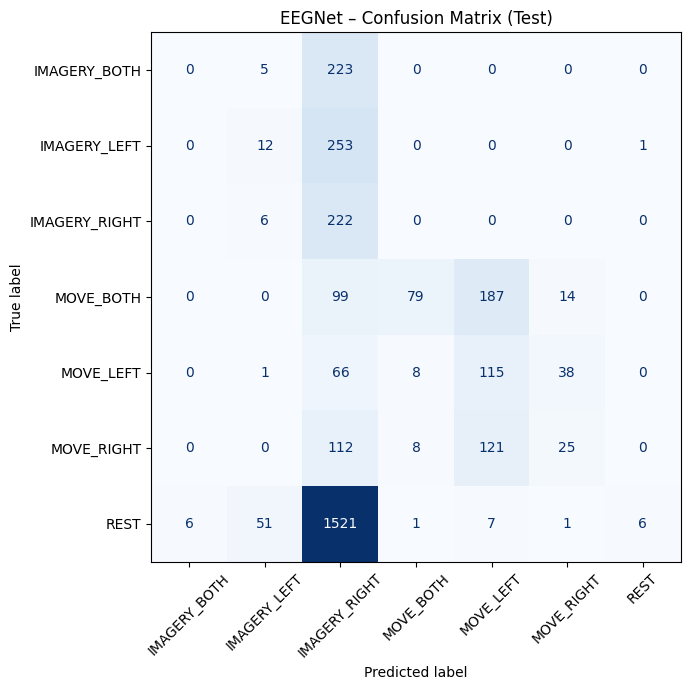

In [14]:
# -----------------------------  Block 8  -----------------------------
# Confusion matrix on test-set
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred = model.predict(X_te4D, verbose=0).argmax(1)
y_true = le.transform(y_te)

print("\nTest classification report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

fig, ax = plt.subplots(figsize=(7,7))
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=le.classes_, cmap='Blues',
    xticks_rotation=45, ax=ax, colorbar=False
)
ax.set_title("EEGNet – Confusion Matrix (Test)")
plt.tight_layout(); plt.show()


In [20]:
# -----------------------------  Block 9  -----------------------------
# Lagre alle artefakter for sanntids-inferens
# --------------------------------------------------------------------
import os, json, numpy as np, tensorflow as tf
save_dir = "./saved_artifacts"
os.makedirs(save_dir, exist_ok=True)

# 1) TF-modell
model.save(os.path.join(save_dir, "EEGNet_MI"))

# 2) Etiketter  →  json + npy
lbl_json = os.path.join(save_dir, "label_classes.json")
lbl_npy  = os.path.join(save_dir, "label_classes.npy")
with open(lbl_json, "w", encoding="utf-8") as f:
    json.dump(le.classes_.tolist(), f, indent=2)
np.save(lbl_npy, le.classes_)                 # back-compat
print("✅ etiketter →", lbl_json, "og", lbl_npy)

# 3) Kanal-rekkefølge
with open(os.path.join(save_dir, "eeg_channels.json"), "w") as f:
    json.dump(feature_cols, f, indent=2)

# 4) Pre-proc-meta
meta_info = {
    "sfreq": sfreq, "window_s": win_s, "window_len": win,
    "step_len": step, "overlap": 0.5,
    "zscore": True, "bandpass": [8, 30], "notch": 50
}
with open(os.path.join(save_dir, "preproc_meta.json"), "w") as f:
    json.dump(meta_info, f, indent=2)


INFO:tensorflow:Assets written to: ./saved_artifacts\EEGNet_MI\assets


INFO:tensorflow:Assets written to: ./saved_artifacts\EEGNet_MI\assets


✅ etiketter → ./saved_artifacts\label_classes.json og ./saved_artifacts\label_classes.npy
